In [14]:
!pip install -r requirements.txt

### Import Dependencies

In [15]:
import pandas as pd
import numpy as np
import openai, groq
import seaborn as sns
from enum import Enum
from pydantic import BaseModel
from dotenv import load_dotenv

load_dotenv()


True

### Basic Information

In [16]:
df = pd.read_csv("raw\ChurnModeling.csv")
df.head(10)

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Eva,Taylor,699,France,Female,NaN,1,0.00,2,0,0,93826.63,0
4,5,15737888,Grace,Miller,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Jack,Smith,645,Spain,Male,44.0,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Carol,Wilson,822,France,Male,50.0,7,0.00,2,1,1,10062.80,0
7,8,15656148,Grace,Wilson,376,Germany,Female,29.0,4,115046.74,4,1,0,119346.88,1
8,9,15792365,Hank,Jones,501,France,Male,44.0,4,142051.07,2,0,1,74940.50,0
9,10,15592389,Eva,Wilson,684,France,Male,27.0,2,134603.88,1,1,1,71725.73,0


In [17]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Firstname            7
Lastname             6
CreditScore          0
Geography            0
Gender             108
Age                600
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

### 3. Handle Missing Values

#### 3.1 Deletion

- Axis = 0 -> Check each column and drop if at least one value is missing
- Axis = 1 -> Check each row and drop if at least one value is missing

In [18]:
df_copy = df.copy()
df_copy = df_copy.dropna(axis=0)
df_copy

,RowNumber,CustomerId,Firstname,Lastname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Grace,Williams,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,2,15647311,David,Jones,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Hank,Williams,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
4,5,15737888,Grace,Miller,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Jack,Smith,645,Spain,Male,44.0,8,113755.78,2,1,0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Grace,Garcia,771,France,Male,39.0,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Jack,Garcia,516,France,Male,35.0,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Carol,Johnson,709,France,Female,36.0,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Jack,Garcia,772,Germany,Male,42.0,3,75075.31,2,1,0,92888.52,1


In [19]:
df_copy = df.copy()
df_copy = df_copy.dropna(axis=1)
df_copy

,RowNumber,CustomerId,CreditScore,Geography,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,France,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,Spain,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,France,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,France,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,Spain,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,France,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,516,France,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,709,France,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,772,Germany,3,75075.31,2,1,0,92888.52,1


#### 3.2 Imputation


- Filling the missing data with mean or median value
- Filling the missing data with mode if it's a categorical value
- Filling the numerical value with 0 or -999, or some other number that will not occur in the data
- Filling the categorical value with a new type for the missing value

##### 3.2.1 Age

In [20]:
mean = df['Age'].mean()
median = df['Age'].median()

mean=round(mean, 2)

print(f"Mean: {mean}\nMedian: {median}")

Mean: 38.91
Median: 37.0


<Axes: xlabel='Age', ylabel='Count'>

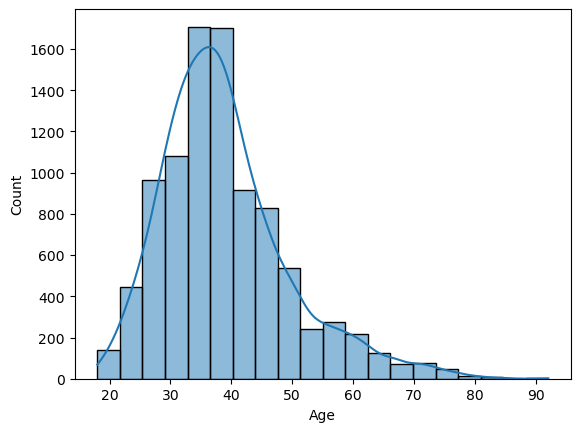

In [21]:
sns.histplot(df['Age'], bins=20, kde=True)

In [22]:
df_impute = df.copy()

In [23]:
df_impute.loc[:, 'Age'] = df_impute['Age'].fillna(mean)

##### 3.2.2 Gender

We are using LLM to infer the gender

In [24]:
class Gender(str, Enum):
    MALE = "Male"
    FEMALE = "Female"

class GenderPrediction(BaseModel):
    firstname: str
    lastname: str
    pred_gender: Gender

def predictGender(firstname: str, lastname: str):
    prompt = f""" 
    What is the most likely gender (Male or Female) for someone with the first name'{firstname}' 
    and last name '{lastname}'?

    Your response should only consists of one word: Male or Female

    """
    response = groq.Groq().chat.completions.create(model="llama-3.3-70b-versatile",
    messages=[{"role": "user", "content": prompt}])

    predicted_gender = response.choices[0].message.content.strip()
    return predicted_gender


In [25]:
predictGender("Samadhi", "Talagala")

'Female'

In [27]:
missing_gender_index = df_impute['Gender'].isnull()
for idx in df_impute[missing_gender_index].index:
    first_name = df_impute.loc[idx, 'Firstname']
    last_name = df_impute.loc[idx, 'Lastname']
    gender = predictGender(first_name, last_name)
    
    if gender:
        df_impute.loc[idx, 'Gender'] = gender
        print(f'{first_name} {last_name} : {gender}')
    else:
        print()

Eva Wilson : Female
Ivy Johnson : Female
David Taylor : Male
Frank Davis : Male
Jack Wilson : Male
David Miller : Male
Eva Taylor : Female
Grace Johnson : Female
Hank Miller : Male
Frank Williams : Male
Alice Davis : Female
Alice Brown : Female
Alice Garcia : Female
Bob Jones : Male
Jack Davis : Male
Grace Williams : Female
Ivy Jones : Female
David Smith : Male
David Miller : Male
Eva Williams : Female
Frank Garcia : Male
Alice Wilson : Female
Carol Jones : Female
Hank Davis : Male
Ivy Williams : Female
Hank Smith : Male
Ivy Jones : Female
Alice Brown : Female
Eva Taylor : Female
Carol Williams : Female
Jack Williams : Male
Ivy Brown : Female
David Brown : Male
Bob Smith : Male
Frank Wilson : Male
Bob Williams : Male
Ivy Johnson : Female
Jack Taylor : Male
David Davis : Male
David Garcia : Male
Eva Brown : Female
Frank Wilson : Male
Jack Davis : Male
Eva Miller : Female
Grace Williams : Female
Bob Jones : Male
David Taylor : Male
Frank Smith : Male
Ivy Jones : Female
David Williams : M

In [28]:
# get null values
df_impute.isnull().sum()

RowNumber          0
CustomerId         0
Firstname          7
Lastname           6
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [29]:
df_impute = df_impute.drop(
                            columns=[
                                    'RowNumber',
                                    'CustomerId',
                                    'Firstname',
                                    'Lastname'
                                    ]
                            )
df_impute.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.00,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41.00,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42.00,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,38.91,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43.00,2,125510.82,1,1,1,79084.10,0


In [30]:
# get null values
df_impute.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
# import os

# os.makedirs('data/processed', exist_ok=True)
df_impute.to_csv(
    'data/processed/ChurnModelling_Missing_Values_Handled.csv', 
    index=False
)